# Predictive-Coding Diffusion (PC-Diffusion) with Heun Sampler

This notebook trains a small diffusion model on CIFAR-10 and samples with a 2nd-order **Heun** ODE solver.
We adopt the EDM training recipe (noise distribution, loss weighting) and step schedule, and re-interpret the denoiser as a **predictive-coding module** that estimates the clean image \(x_0\) from \(x_\sigma\); the per-step **error** acts as the predictive-coding residual.

**Key references**
- Heun sampler, schedules, loss preconditioning and weighting: *Elucidating the Design Space of Diffusion-Based Generative Models (EDM)* — see Algorithm 1 and Table 1 for exact formulas. :contentReference[oaicite:2]{index=2}
- Probability-flow ODE connection used for deterministic sampling (we solve the ODE with Heun): *Score-based Generative Modeling through Stochastic Differential Equations*. :contentReference[oaicite:3]{index=3}

**What you get**
- Minimal UNet-like denoiser with time (noise) embedding
- EDM-style noise sampling and loss weighting
- Heun (2nd order) sampler that mirrors EDM Algorithm 1
- Optional “Lyapunov head” that predicts log-noise (a scalar energy proxy) to monitor monotonic decrease during sampling
- End-to-end training on CIFAR-10 and a demo sampler


# Setup

In [1]:
# If you're running locally and miss einops or torchvision, uncomment:
# !pip install -q einops torchvision

import math
import os
import random
from dataclasses import dataclass
from typing import Optional, Tuple

import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as T

from torch.utils.data import DataLoader
from einops import rearrange


In [2]:
@dataclass
class Config:
    # Data
    dataset: str = "CIFAR10"
    data_root: str = "./data"
    image_size: int = 32
    channels: int = 3

    # Training
    batch_size: int = 128
    num_workers: int = 4
    epochs: int = 300           # deeper schedule for larger model
    lr: float = 3e-4
    lr_min: float = 1e-5
    ema_decay: float = 0.9999
    grad_clip: float = 1.0
    weight_decay: float = 0.01
    loss_v_weight: float = 0.01

    # EDM loss hyperparameters
    sigma_data: float = 0.5
    P_mean: float = -1.2       # log-normal distribution of sigma ~ LogN(P_mean, P_std^2)
    P_std: float = 1.2

    # Sampler
    sample_steps: int = 40     # number of NFE for Heun sampler
    sigma_min: float = 0.002
    sigma_max: float = 80.0
    rho: float = 7.0           # Karras EDM rho schedule parameter

    # Model
    base_channels: int = 128
    channel_mults: Tuple[int, ...] = (1, 2, 3, 4, 6)  # deeper UNet hierarchy
    num_res_blocks: int = 3
    dropout: float = 0.1
    attn_resolutions: Tuple[int, ...] = (16, 8)
    attn_heads: int = 8
    norm_groups: int = 32
    with_v_head: bool = True   # "Lyapunov" head (scalar energy correlated with noise)

    # Logging/saving
    out_dir: str = "./pc_diffusion_ckpt"
    device: str = "cuda" if torch.cuda.is_available() else "cpu"
    seed: int = 42

cfg = Config()

# Reproducibility
def seed_everything(seed=42):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.benchmark = True
seed_everything(cfg.seed)

os.makedirs(cfg.out_dir, exist_ok=True)
print(cfg)


Config(dataset='CIFAR10', data_root='./data', image_size=32, channels=3, batch_size=128, num_workers=4, epochs=300, lr=0.0003, lr_min=1e-05, ema_decay=0.9999, grad_clip=1.0, weight_decay=0.01, loss_v_weight=0.01, sigma_data=0.5, P_mean=-1.2, P_std=1.2, sample_steps=40, sigma_min=0.002, sigma_max=80.0, rho=7.0, base_channels=128, channel_mults=(1, 2, 3, 4, 6), num_res_blocks=3, dropout=0.1, attn_resolutions=(16, 8), attn_heads=8, norm_groups=32, with_v_head=True, out_dir='./pc_diffusion_ckpt', device='cuda', seed=42)


# data

In [3]:
transform = T.Compose([
    T.RandomHorizontalFlip(),
    T.ToTensor(),
    # CIFAR10 is in [0,1]; center to [-1,1] as common in diffusion code
    T.Lambda(lambda x: x * 2.0 - 1.0),
])

trainset = torchvision.datasets.CIFAR10(
    root=cfg.data_root, train=True, download=True, transform=transform)
testset = torchvision.datasets.CIFAR10(
    root=cfg.data_root, train=False, download=True, transform=T.Compose([
        T.ToTensor(),
        T.Lambda(lambda x: x * 2.0 - 1.0),
    ])
)

train_loader = DataLoader(trainset, batch_size=cfg.batch_size,
                          shuffle=True, num_workers=cfg.num_workers, drop_last=True)
test_loader = DataLoader(testset, batch_size=cfg.batch_size,
                         shuffle=False, num_workers=cfg.num_workers, drop_last=False)

print("Train batches:", len(train_loader), "Test batches:", len(test_loader))


Train batches: 390 Test batches: 79


# network

In [4]:
class SinusoidalTimeEmbedding(nn.Module):
    """
    Sinusoidal embedding followed by a small MLP to produce t-embedding.
    Input is a scalar per batch item (we'll feed log_sigma).
    """
    def __init__(self, emb_dim: int, hidden_dim: int = 256):
        super().__init__()
        self.emb_dim = emb_dim
        half = emb_dim // 2
        self.register_buffer(
            "frequencies",
            torch.exp(torch.linspace(math.log(1.0), math.log(10000.0), half))
        )
        self.mlp = nn.Sequential(
            nn.Linear(emb_dim, hidden_dim),
            nn.SiLU(),
            nn.Linear(hidden_dim, hidden_dim),
            nn.SiLU()
        )
        self.out_dim = hidden_dim

    def forward(self, t_scalar: torch.Tensor) -> torch.Tensor:
        t = t_scalar.unsqueeze(-1)
        sin = torch.sin(t * self.frequencies)
        cos = torch.cos(t * self.frequencies)
        temb = torch.cat([sin, cos], dim=-1)
        return self.mlp(temb)


def conv3x3(in_ch, out_ch, bias=True):
    return nn.Conv2d(in_ch, out_ch, kernel_size=3, padding=1, bias=bias)


def make_group_norm(channels: int, max_groups: int = 32):
    num_groups = min(max_groups, channels)
    while channels % num_groups != 0 and num_groups > 1:
        num_groups -= 1
    return nn.GroupNorm(num_groups, channels)


class ResBlock(nn.Module):
    def __init__(self, in_ch: int, out_ch: int, t_dim: int, max_groups: int = 32, dropout: float = 0.0):
        super().__init__()
        self.norm1 = make_group_norm(in_ch, max_groups)
        self.act1 = nn.SiLU()
        self.conv1 = conv3x3(in_ch, out_ch)
        self.t_proj = nn.Linear(t_dim, out_ch)
        self.norm2 = make_group_norm(out_ch, max_groups)
        self.act2 = nn.SiLU()
        self.dropout = nn.Dropout(dropout)
        self.conv2 = conv3x3(out_ch, out_ch)
        self.skip = nn.Identity() if in_ch == out_ch else nn.Conv2d(in_ch, out_ch, 1)

    def forward(self, x: torch.Tensor, t_emb: torch.Tensor) -> torch.Tensor:
        h = self.conv1(self.act1(self.norm1(x)))
        h = h + self.t_proj(t_emb)[:, :, None, None]
        h = self.conv2(self.dropout(self.act2(self.norm2(h))))
        return h + self.skip(x)


class AttentionBlock(nn.Module):
    """Simple spatial self-attention over HxW positions."""
    def __init__(self, channels: int, num_heads: int = 4):
        super().__init__()
        if channels % num_heads != 0:
            raise ValueError(f"channels ({channels}) must be divisible by num_heads ({num_heads})")
        self.num_heads = num_heads
        self.head_dim = channels // num_heads
        self.scale = self.head_dim ** -0.5
        self.norm = make_group_norm(channels)
        self.qkv = nn.Conv2d(channels, channels * 3, kernel_size=1)
        self.proj = nn.Conv2d(channels, channels, kernel_size=1)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        b, c, h, w = x.shape
        residual = x
        h_norm = self.norm(x)
        q, k, v = self.qkv(h_norm).chunk(3, dim=1)
        q = q.view(b, self.num_heads, self.head_dim, h * w).permute(0, 1, 3, 2)  # (b, heads, hw, head_dim)
        k = k.view(b, self.num_heads, self.head_dim, h * w)  # (b, heads, head_dim, hw)
        attn = torch.matmul(q, k) * self.scale
        attn = attn.softmax(dim=-1)
        v = v.view(b, self.num_heads, self.head_dim, h * w).permute(0, 1, 3, 2)  # (b, heads, hw, head_dim)
        out = torch.matmul(attn, v)  # (b, heads, hw, head_dim)
        out = out.permute(0, 1, 3, 2).reshape(b, c, h, w)
        out = self.proj(out)
        return residual + out


class ResAttnBlock(nn.Module):
    def __init__(self, in_ch: int, out_ch: int, t_dim: int, max_groups: int = 32, dropout: float = 0.0,
                 use_attention: bool = False, num_heads: int = 4):
        super().__init__()
        self.resblock = ResBlock(in_ch, out_ch, t_dim, max_groups=max_groups, dropout=dropout)
        self.attn = AttentionBlock(out_ch, num_heads=num_heads) if use_attention else None

    def forward(self, x: torch.Tensor, t_emb: torch.Tensor) -> torch.Tensor:
        h = self.resblock(x, t_emb)
        if self.attn is not None:
            h = self.attn(h)
        return h


class MiniUNet(nn.Module):
    """
    UNet with configurable depth, spatial attention, and predictive-coding head.
    """
    def __init__(
        self,
        in_ch: int = 3,
        base: int = 64,
        ch_mult=(1, 2, 4),
        num_res_blocks: int = 2,
        t_emb_dim: int = 128,
        t_hidden: int = 256,
        dropout: float = 0.0,
        with_v_head: bool = True,
        image_size: int = 32,
        attn_resolutions=(16,),
        num_heads: int = 4,
        norm_groups: int = 32
    ):
        super().__init__()
        self.with_v_head = with_v_head
        self.num_levels = len(ch_mult)
        self.num_res_blocks = num_res_blocks
        self.attn_resolutions = set(attn_resolutions) if attn_resolutions else set()
        self.num_heads = num_heads

        if image_size % (2 ** (self.num_levels - 1)) != 0:
            raise ValueError("image_size must be divisible by 2^(levels-1)")
        self.resolutions = [image_size // (2 ** i) for i in range(self.num_levels)]

        self.t_embed = SinusoidalTimeEmbedding(t_emb_dim, hidden_dim=t_hidden)
        t_dim = self.t_embed.out_dim

        chs = [base * m for m in ch_mult]
        self.stem = conv3x3(in_ch, chs[0])

        self.enc_blocks = nn.ModuleList()
        self.downsamples = nn.ModuleList()
        in_channels = chs[0]
        for level, ch in enumerate(chs):
            res = self.resolutions[level]
            blocks = nn.ModuleList()
            for _ in range(num_res_blocks):
                use_attn = res in self.attn_resolutions
                blocks.append(ResAttnBlock(
                    in_channels, ch, t_dim, max_groups=norm_groups, dropout=dropout,
                    use_attention=use_attn, num_heads=num_heads
                ))
                in_channels = ch
            self.enc_blocks.append(blocks)
            if level != self.num_levels - 1:
                down = nn.Conv2d(in_channels, chs[level + 1], 3, stride=2, padding=1)
                self.downsamples.append(down)
                in_channels = chs[level + 1]

        self.mid_blocks = nn.ModuleList([
            ResAttnBlock(in_channels, in_channels, t_dim, max_groups=norm_groups, dropout=dropout,
                         use_attention=True, num_heads=num_heads),
            ResAttnBlock(in_channels, in_channels, t_dim, max_groups=norm_groups, dropout=dropout,
                         use_attention=True, num_heads=num_heads)
        ])

        self.dec_blocks = nn.ModuleList()
        self.upsamples = nn.ModuleList()
        current_ch = in_channels
        for level in reversed(range(self.num_levels)):
            ch = chs[level]
            res = self.resolutions[level]
            blocks = nn.ModuleList()
            for _ in range(num_res_blocks):
                use_attn = res in self.attn_resolutions
                blocks.append(ResAttnBlock(
                    current_ch + ch, ch, t_dim, max_groups=norm_groups, dropout=dropout,
                    use_attention=use_attn, num_heads=num_heads
                ))
                current_ch = ch
            self.dec_blocks.append(blocks)
            if level != 0:
                up = nn.ConvTranspose2d(current_ch, chs[level - 1], 2, stride=2)
                self.upsamples.append(up)
                current_ch = chs[level - 1]

        self.out_channels = current_ch
        self.out_norm = make_group_norm(self.out_channels, norm_groups)
        self.out = conv3x3(self.out_channels, in_ch)
        if self.with_v_head:
            self.v_head = nn.Conv2d(self.out_channels, 1, 1)

    def forward(self, x: torch.Tensor, log_sigma: torch.Tensor):
        # Broadcast scalar noise inputs during deterministic sampling
        if log_sigma.ndim == 0:
            log_sigma = log_sigma.expand(x.size(0))
        elif log_sigma.ndim == 1 and log_sigma.shape[0] == 1 and x.size(0) > 1:
            log_sigma = log_sigma.expand(x.size(0))
        log_sigma = log_sigma.reshape(x.size(0)).to(x.device, dtype=self.t_embed.frequencies.dtype)
        t_emb = self.t_embed(log_sigma)

        h = self.stem(x)
        skips = []
        for level, blocks in enumerate(self.enc_blocks):
            for block in blocks:
                h = block(h, t_emb)
                skips.append(h)
            if level != self.num_levels - 1:
                h = self.downsamples[level](h)

        for block in self.mid_blocks:
            h = block(h, t_emb)

        dec_block_idx = 0
        up_idx = 0
        for level in reversed(range(self.num_levels)):
            blocks = self.dec_blocks[dec_block_idx]
            for block in blocks:
                skip = skips.pop()
                h = torch.cat([h, skip], dim=1)
                h = block(h, t_emb)
            if level != 0:
                h = self.upsamples[up_idx](h)
                up_idx += 1
            dec_block_idx += 1

        h = self.out_norm(h)
        h = F.silu(h)
        x0_hat = torch.tanh(self.out(h))

        if self.with_v_head:
            v = self.v_head(h)
            return x0_hat, v
        else:
            dummy = torch.zeros(x.size(0), 1, 1, 1, device=x.device, dtype=x.dtype)
            return x0_hat, dummy


class EDMSchedule:
    """EDM sigma sampling and loss weighting (Table 1 in EDM).
    """
    def __init__(self, sigma_data=0.5, P_mean=-1.2, P_std=1.2):
        self.sigma_data = float(sigma_data)
        self.P_mean = float(P_mean)
        self.P_std = float(P_std)

    def sample_sigma(self, batch_size, device):
        # ln sigma ~ N(P_mean, P_std^2)
        log_sigma = torch.randn(batch_size, device=device) * self.P_std + self.P_mean
        sigma = torch.exp(log_sigma)
        return sigma, log_sigma

    def loss_weight(self, sigma):
        # λ(σ) = ((σ^2 + σ_data^2) / (σ * σ_data))^2   -- EDM
        s2 = sigma**2
        sd2 = self.sigma_data**2
        w = ((s2 + sd2) / (sigma * self.sigma_data))**2
        return w

In [5]:
def update_ema(ema_model, model, decay):
    with torch.no_grad():
        msd = model.state_dict()
        for k, v in ema_model.state_dict().items():
            if k in msd:
                v.copy_(v * decay + msd[k] * (1 - decay))

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = MiniUNet(
    in_ch=cfg.channels,
    base=cfg.base_channels,
    ch_mult=cfg.channel_mults,
    num_res_blocks=cfg.num_res_blocks,
    t_emb_dim=256,
    t_hidden=512,
    dropout=cfg.dropout,
    with_v_head=cfg.with_v_head,
    image_size=cfg.image_size,
    attn_resolutions=cfg.attn_resolutions,
    num_heads=cfg.attn_heads,
    norm_groups=cfg.norm_groups,
).to(device)

ema_model = MiniUNet(
    in_ch=cfg.channels,
    base=cfg.base_channels,
    ch_mult=cfg.channel_mults,
    num_res_blocks=cfg.num_res_blocks,
    t_emb_dim=256,
    t_hidden=512,
    dropout=cfg.dropout,
    with_v_head=cfg.with_v_head,
    image_size=cfg.image_size,
    attn_resolutions=cfg.attn_resolutions,
    num_heads=cfg.attn_heads,
    norm_groups=cfg.norm_groups,
).to(device)
ema_model.load_state_dict(model.state_dict())

opt = torch.optim.AdamW(
    model.parameters(), lr=cfg.lr, betas=(0.9, 0.995), weight_decay=cfg.weight_decay
 )
total_steps = max(1, cfg.epochs * len(train_loader))
lr_scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(
    opt, T_max=total_steps, eta_min=cfg.lr_min
 )
sched = EDMSchedule(sigma_data=cfg.sigma_data, P_mean=cfg.P_mean, P_std=cfg.P_std)


In [6]:
def training_step(x0):
    """
    EDM training:
    - sample sigma
    - form x_sigma = x0 + n, where n ~ N(0, sigma^2)
    - predict x0_hat = D_theta(x_sigma, log_sigma)
    - loss = w(sigma) * || x0_hat - x0 ||^2 + (optional) alpha * || log_sigma_hat - log_sigma ||^2
    """
    B = x0.size(0)
    sigma, log_sigma = sched.sample_sigma(B, x0.device)
    noise = torch.randn_like(x0) * sigma[:, None, None, None]
    x_sigma = x0 + noise

    x0_hat, v = model(x_sigma, log_sigma)
    w = sched.loss_weight(sigma)
    mse = (x0_hat - x0).pow(2).mean(dim=(1,2,3))
    loss_denoise = (w * mse).mean()

    # Optional Lyapunov/energy head: supervise v ~ log_sigma
    # Average spatially and across channels to compare against scalar log_sigma.
    loss_v = torch.tensor(0.0, device=x0.device)
    if cfg.with_v_head:
        v_scalar = v.mean(dim=(1,2,3))
        loss_v = F.mse_loss(v_scalar, log_sigma)

    loss = loss_denoise + cfg.loss_v_weight * loss_v
    return loss, {"loss_denoise": loss_denoise.item(), "loss_v": loss_v.item()}


In [7]:
from tqdm import tqdm

def train():
    model.train()
    global_step = 0
    for epoch in range(cfg.epochs):
        pbar = tqdm(train_loader, desc=f"Epoch {epoch+1}/{cfg.epochs}", leave=False)
        epoch_loss = 0.0
        epoch_loss_v = 0.0
        batches = 0
        for (x, _) in pbar:
            x = x.to(device)

            opt.zero_grad(set_to_none=True)
            loss, logs = training_step(x)
            loss.backward()
            if cfg.grad_clip is not None:
                torch.nn.utils.clip_grad_norm_(model.parameters(), cfg.grad_clip)
            opt.step()
            lr_scheduler.step()

            update_ema(ema_model, model, cfg.ema_decay)

            global_step += 1
            epoch_loss += logs.get("loss_denoise", 0.0)
            epoch_loss_v += logs.get("loss_v", 0.0)
            batches += 1
            if global_step % 50 == 0:
                display_logs = {k: f"{v:.4f}" for k, v in logs.items()}
                display_logs["lr"] = f"{lr_scheduler.get_last_lr()[0]:.2e}"
                pbar.set_postfix(display_logs)
        # Save a checkpoint per epoch
        avg_loss = epoch_loss / max(1, batches)
        avg_loss_v = epoch_loss_v / max(1, batches)
        current_lr = lr_scheduler.get_last_lr()[0]
        print(f"Epoch {epoch+1}: avg_loss={avg_loss:.4f}, avg_loss_v={avg_loss_v:.4f}, lr={current_lr:.2e}")
        if (epoch+1) % 30 == 0:
            torch.save(ema_model.state_dict(), os.path.join(cfg.out_dir, f"ema_epoch_{epoch+1}.pt"))
    print("Training complete.")

train()


Epoch 1: avg_loss=1.6541, avg_loss_v=1.5164, lr=3.00e-04


Epoch 2: avg_loss=1.3812, avg_loss_v=0.7131, lr=3.00e-04


Epoch 3: avg_loss=1.5662, avg_loss_v=0.3821, lr=3.00e-04


Epoch 4: avg_loss=1.1014, avg_loss_v=0.2587, lr=3.00e-04


Epoch 5: avg_loss=1.3030, avg_loss_v=0.1809, lr=3.00e-04


Epoch 6: avg_loss=1.0875, avg_loss_v=0.1449, lr=3.00e-04


Epoch 7: avg_loss=1.0212, avg_loss_v=0.1370, lr=3.00e-04


Epoch 8: avg_loss=1.1014, avg_loss_v=0.1255, lr=2.99e-04


Epoch 9: avg_loss=1.0227, avg_loss_v=0.1171, lr=2.99e-04


Epoch 10: avg_loss=1.1399, avg_loss_v=0.1100, lr=2.99e-04


Epoch 11: avg_loss=1.0859, avg_loss_v=0.0818, lr=2.99e-04


Epoch 12: avg_loss=0.9530, avg_loss_v=0.1084, lr=2.99e-04


Epoch 13: avg_loss=0.9741, avg_loss_v=0.0936, lr=2.99e-04


Epoch 14: avg_loss=1.0360, avg_loss_v=0.0776, lr=2.98e-04


Epoch 15: avg_loss=1.0881, avg_loss_v=0.0730, lr=2.98e-04


Epoch 16: avg_loss=0.8540, avg_loss_v=0.0829, lr=2.98e-04


Epoch 17: avg_loss=1.0657, avg_loss_v=0.0741, lr=2.98e-04


Epoch 18: avg_loss=0.9158, avg_loss_v=0.0615, lr=2.97e-04


Epoch 19: avg_loss=0.9488, avg_loss_v=0.0587, lr=2.97e-04


Epoch 20: avg_loss=0.9557, avg_loss_v=0.0504, lr=2.97e-04


Epoch 21: avg_loss=1.1353, avg_loss_v=0.0573, lr=2.97e-04


Epoch 22: avg_loss=0.8888, avg_loss_v=0.0478, lr=2.96e-04


Epoch 23: avg_loss=0.9687, avg_loss_v=0.0528, lr=2.96e-04


Epoch 24: avg_loss=0.9323, avg_loss_v=0.0451, lr=2.95e-04


Epoch 25: avg_loss=0.9252, avg_loss_v=0.0445, lr=2.95e-04


Epoch 26: avg_loss=0.9418, avg_loss_v=0.0370, lr=2.95e-04


Epoch 27: avg_loss=0.8678, avg_loss_v=0.0489, lr=2.94e-04


Epoch 28: avg_loss=1.0804, avg_loss_v=0.0557, lr=2.94e-04


Epoch 29: avg_loss=0.9478, avg_loss_v=0.0420, lr=2.93e-04


Epoch 30: avg_loss=1.0429, avg_loss_v=0.0403, lr=2.93e-04


Epoch 31: avg_loss=0.8705, avg_loss_v=0.0363, lr=2.92e-04


Epoch 32: avg_loss=1.6344, avg_loss_v=0.0372, lr=2.92e-04


Epoch 33: avg_loss=0.9666, avg_loss_v=0.0330, lr=2.91e-04


Epoch 34: avg_loss=0.8552, avg_loss_v=0.0364, lr=2.91e-04


Epoch 35: avg_loss=0.9483, avg_loss_v=0.0391, lr=2.90e-04


Epoch 36: avg_loss=0.9821, avg_loss_v=0.0285, lr=2.90e-04


Epoch 37: avg_loss=0.8207, avg_loss_v=0.0291, lr=2.89e-04


Epoch 38: avg_loss=0.9647, avg_loss_v=0.0310, lr=2.89e-04


Epoch 39: avg_loss=0.8633, avg_loss_v=0.0278, lr=2.88e-04


Epoch 40: avg_loss=0.9214, avg_loss_v=0.0297, lr=2.87e-04


Epoch 41: avg_loss=1.0482, avg_loss_v=0.0310, lr=2.87e-04


Epoch 42: avg_loss=1.1216, avg_loss_v=0.0278, lr=2.86e-04


Epoch 43: avg_loss=0.9593, avg_loss_v=0.0256, lr=2.86e-04


Epoch 44: avg_loss=0.8859, avg_loss_v=0.0275, lr=2.85e-04


Epoch 45: avg_loss=0.9438, avg_loss_v=0.0245, lr=2.84e-04


Epoch 46: avg_loss=0.8577, avg_loss_v=0.0247, lr=2.83e-04


Epoch 47: avg_loss=1.0460, avg_loss_v=0.0283, lr=2.83e-04


Epoch 48: avg_loss=0.8198, avg_loss_v=0.0215, lr=2.82e-04


Epoch 49: avg_loss=1.3460, avg_loss_v=0.0271, lr=2.81e-04


Epoch 50: avg_loss=0.8566, avg_loss_v=0.0211, lr=2.81e-04


Epoch 51: avg_loss=0.8289, avg_loss_v=0.0226, lr=2.80e-04


Epoch 52: avg_loss=0.9461, avg_loss_v=0.0224, lr=2.79e-04


Epoch 53: avg_loss=0.8643, avg_loss_v=0.0233, lr=2.78e-04


Epoch 54: avg_loss=0.8259, avg_loss_v=0.0256, lr=2.77e-04


Epoch 55: avg_loss=0.8951, avg_loss_v=0.0210, lr=2.77e-04


Epoch 56: avg_loss=0.9025, avg_loss_v=0.0231, lr=2.76e-04


Epoch 57: avg_loss=1.0029, avg_loss_v=0.0211, lr=2.75e-04


Epoch 58: avg_loss=0.9283, avg_loss_v=0.0209, lr=2.74e-04


Epoch 59: avg_loss=0.8264, avg_loss_v=0.0212, lr=2.73e-04


Epoch 60: avg_loss=0.9724, avg_loss_v=0.0238, lr=2.72e-04


Epoch 61: avg_loss=0.8935, avg_loss_v=0.0187, lr=2.71e-04


Epoch 62: avg_loss=1.0439, avg_loss_v=0.0181, lr=2.70e-04


Epoch 63: avg_loss=0.8310, avg_loss_v=0.0183, lr=2.70e-04


Epoch 64: avg_loss=0.8950, avg_loss_v=0.0184, lr=2.69e-04


Epoch 65: avg_loss=1.5017, avg_loss_v=0.0195, lr=2.68e-04


Epoch 66: avg_loss=0.9803, avg_loss_v=0.0195, lr=2.67e-04


Epoch 67: avg_loss=0.8882, avg_loss_v=0.0159, lr=2.66e-04


Epoch 68: avg_loss=1.0624, avg_loss_v=0.0194, lr=2.65e-04


Epoch 69: avg_loss=0.9139, avg_loss_v=0.0173, lr=2.64e-04


Epoch 70: avg_loss=0.9859, avg_loss_v=0.0174, lr=2.63e-04


Epoch 71: avg_loss=0.8642, avg_loss_v=0.0153, lr=2.62e-04


Epoch 72: avg_loss=1.0159, avg_loss_v=0.0166, lr=2.61e-04


Epoch 73: avg_loss=0.8057, avg_loss_v=0.0162, lr=2.60e-04


Epoch 74: avg_loss=0.9371, avg_loss_v=0.0186, lr=2.59e-04


Epoch 75: avg_loss=0.9047, avg_loss_v=0.0186, lr=2.58e-04


Epoch 76: avg_loss=0.8781, avg_loss_v=0.0159, lr=2.56e-04


Epoch 77: avg_loss=0.9523, avg_loss_v=0.0175, lr=2.55e-04


Epoch 78: avg_loss=1.1464, avg_loss_v=0.0164, lr=2.54e-04


Epoch 79: avg_loss=0.9414, avg_loss_v=0.0151, lr=2.53e-04


Epoch 80: avg_loss=0.7848, avg_loss_v=0.0147, lr=2.52e-04


Epoch 81: avg_loss=1.0481, avg_loss_v=0.0167, lr=2.51e-04


Epoch 82: avg_loss=0.8058, avg_loss_v=0.0140, lr=2.50e-04


Epoch 83: avg_loss=0.8481, avg_loss_v=0.0150, lr=2.49e-04


Epoch 84: avg_loss=0.8808, avg_loss_v=0.0146, lr=2.47e-04


Epoch 85: avg_loss=0.7925, avg_loss_v=0.0138, lr=2.46e-04


Epoch 86: avg_loss=0.8693, avg_loss_v=0.0144, lr=2.45e-04


Epoch 87: avg_loss=0.9552, avg_loss_v=0.0159, lr=2.44e-04


Epoch 88: avg_loss=0.8406, avg_loss_v=0.0143, lr=2.43e-04


Epoch 89: avg_loss=0.9201, avg_loss_v=0.0134, lr=2.41e-04


Epoch 90: avg_loss=0.8712, avg_loss_v=0.0163, lr=2.40e-04


Epoch 91: avg_loss=0.9220, avg_loss_v=0.0136, lr=2.39e-04


Epoch 92: avg_loss=0.9898, avg_loss_v=0.0144, lr=2.38e-04


Epoch 93: avg_loss=0.9921, avg_loss_v=0.0147, lr=2.37e-04


Epoch 94: avg_loss=1.0016, avg_loss_v=0.0131, lr=2.35e-04


Epoch 95: avg_loss=1.0223, avg_loss_v=0.0140, lr=2.34e-04


Epoch 96: avg_loss=0.8548, avg_loss_v=0.0130, lr=2.33e-04


Epoch 97: avg_loss=1.0190, avg_loss_v=0.0122, lr=2.31e-04


Epoch 98: avg_loss=0.8516, avg_loss_v=0.0128, lr=2.30e-04


Epoch 99: avg_loss=1.0477, avg_loss_v=0.0142, lr=2.29e-04


Epoch 100: avg_loss=0.7338, avg_loss_v=0.0124, lr=2.28e-04


Epoch 101: avg_loss=0.8598, avg_loss_v=0.0139, lr=2.26e-04


Epoch 102: avg_loss=1.0253, avg_loss_v=0.0125, lr=2.25e-04


Epoch 103: avg_loss=0.8738, avg_loss_v=0.0126, lr=2.24e-04


Epoch 104: avg_loss=0.9280, avg_loss_v=0.0136, lr=2.22e-04


Epoch 105: avg_loss=0.8955, avg_loss_v=0.0127, lr=2.21e-04


Epoch 106: avg_loss=0.9108, avg_loss_v=0.0126, lr=2.19e-04


Epoch 107: avg_loss=0.9234, avg_loss_v=0.0130, lr=2.18e-04


Epoch 108: avg_loss=0.9690, avg_loss_v=0.0124, lr=2.17e-04


Epoch 109: avg_loss=0.8652, avg_loss_v=0.0118, lr=2.15e-04


Epoch 110: avg_loss=0.9464, avg_loss_v=0.0120, lr=2.14e-04


Epoch 111: avg_loss=0.7944, avg_loss_v=0.0117, lr=2.13e-04


Epoch 112: avg_loss=0.8896, avg_loss_v=0.0114, lr=2.11e-04


Epoch 113: avg_loss=0.8171, avg_loss_v=0.0104, lr=2.10e-04


Epoch 114: avg_loss=0.7818, avg_loss_v=0.0115, lr=2.08e-04


Epoch 115: avg_loss=0.9237, avg_loss_v=0.0111, lr=2.07e-04


Epoch 116: avg_loss=0.9469, avg_loss_v=0.0112, lr=2.06e-04


Epoch 117: avg_loss=1.1649, avg_loss_v=0.0134, lr=2.04e-04


Epoch 118: avg_loss=0.8259, avg_loss_v=0.0106, lr=2.03e-04


Epoch 119: avg_loss=0.9636, avg_loss_v=0.0100, lr=2.01e-04


Epoch 120: avg_loss=0.9074, avg_loss_v=0.0101, lr=2.00e-04


Epoch 121: avg_loss=0.9029, avg_loss_v=0.0106, lr=1.98e-04


Epoch 122: avg_loss=1.0442, avg_loss_v=0.0117, lr=1.97e-04


Epoch 123: avg_loss=0.8209, avg_loss_v=0.0111, lr=1.95e-04


Epoch 124: avg_loss=0.9025, avg_loss_v=0.0123, lr=1.94e-04


Epoch 125: avg_loss=0.8217, avg_loss_v=0.0098, lr=1.93e-04


Epoch 126: avg_loss=1.0487, avg_loss_v=0.0103, lr=1.91e-04


Epoch 127: avg_loss=0.8816, avg_loss_v=0.0100, lr=1.90e-04


Epoch 128: avg_loss=0.8945, avg_loss_v=0.0099, lr=1.88e-04


Epoch 129: avg_loss=0.9122, avg_loss_v=0.0114, lr=1.87e-04


Epoch 130: avg_loss=1.1392, avg_loss_v=0.0098, lr=1.85e-04


Epoch 131: avg_loss=0.8952, avg_loss_v=0.0100, lr=1.84e-04


Epoch 132: avg_loss=1.0143, avg_loss_v=0.0104, lr=1.82e-04


Epoch 133: avg_loss=0.8374, avg_loss_v=0.0097, lr=1.81e-04


Epoch 134: avg_loss=0.8868, avg_loss_v=0.0092, lr=1.79e-04


Epoch 135: avg_loss=0.8101, avg_loss_v=0.0096, lr=1.78e-04


Epoch 136: avg_loss=0.8065, avg_loss_v=0.0087, lr=1.76e-04


Epoch 137: avg_loss=0.8817, avg_loss_v=0.0095, lr=1.75e-04


Epoch 138: avg_loss=0.8834, avg_loss_v=0.0093, lr=1.73e-04


Epoch 139: avg_loss=0.9860, avg_loss_v=0.0107, lr=1.72e-04


Epoch 140: avg_loss=0.9798, avg_loss_v=0.0103, lr=1.70e-04


Epoch 141: avg_loss=1.1116, avg_loss_v=0.0111, lr=1.69e-04


Epoch 142: avg_loss=0.9027, avg_loss_v=0.0107, lr=1.67e-04


Epoch 143: avg_loss=0.9894, avg_loss_v=0.0089, lr=1.66e-04


Epoch 144: avg_loss=0.8312, avg_loss_v=0.0089, lr=1.64e-04


Epoch 145: avg_loss=0.8451, avg_loss_v=0.0093, lr=1.63e-04


Epoch 146: avg_loss=0.8601, avg_loss_v=0.0082, lr=1.61e-04


Epoch 147: avg_loss=0.7976, avg_loss_v=0.0093, lr=1.60e-04


Epoch 148: avg_loss=0.9399, avg_loss_v=0.0089, lr=1.58e-04


Epoch 149: avg_loss=0.8565, avg_loss_v=0.0082, lr=1.57e-04


Epoch 150: avg_loss=0.8189, avg_loss_v=0.0083, lr=1.55e-04


Epoch 151: avg_loss=0.8520, avg_loss_v=0.0075, lr=1.53e-04


Epoch 152: avg_loss=0.8689, avg_loss_v=0.0083, lr=1.52e-04


Epoch 153: avg_loss=0.9115, avg_loss_v=0.0083, lr=1.50e-04


Epoch 154: avg_loss=0.8140, avg_loss_v=0.0076, lr=1.49e-04


Epoch 155: avg_loss=1.0046, avg_loss_v=0.0083, lr=1.47e-04


Epoch 156: avg_loss=0.9086, avg_loss_v=0.0085, lr=1.46e-04


Epoch 157: avg_loss=0.8261, avg_loss_v=0.0073, lr=1.44e-04


Epoch 158: avg_loss=1.0350, avg_loss_v=0.0081, lr=1.43e-04


Epoch 159: avg_loss=0.8028, avg_loss_v=0.0078, lr=1.41e-04


Epoch 160: avg_loss=0.8314, avg_loss_v=0.0082, lr=1.40e-04


Epoch 161: avg_loss=0.8010, avg_loss_v=0.0077, lr=1.38e-04


Epoch 162: avg_loss=1.0293, avg_loss_v=0.0080, lr=1.37e-04


Epoch 163: avg_loss=0.8934, avg_loss_v=0.0089, lr=1.35e-04


Epoch 164: avg_loss=0.7502, avg_loss_v=0.0072, lr=1.34e-04


Epoch 165: avg_loss=0.8941, avg_loss_v=0.0078, lr=1.32e-04


Epoch 166: avg_loss=0.9192, avg_loss_v=0.0076, lr=1.31e-04


Epoch 167: avg_loss=0.8646, avg_loss_v=0.0084, lr=1.29e-04


Epoch 168: avg_loss=0.7505, avg_loss_v=0.0074, lr=1.28e-04


Epoch 169: avg_loss=0.8766, avg_loss_v=0.0079, lr=1.26e-04


Epoch 170: avg_loss=0.7897, avg_loss_v=0.0074, lr=1.25e-04


Epoch 171: avg_loss=0.8783, avg_loss_v=0.0073, lr=1.23e-04


Epoch 172: avg_loss=0.8952, avg_loss_v=0.0072, lr=1.22e-04


Epoch 173: avg_loss=0.8981, avg_loss_v=0.0082, lr=1.20e-04


Epoch 174: avg_loss=0.9292, avg_loss_v=0.0076, lr=1.19e-04


Epoch 175: avg_loss=0.9125, avg_loss_v=0.0072, lr=1.17e-04


Epoch 176: avg_loss=0.9982, avg_loss_v=0.0081, lr=1.16e-04


Epoch 177: avg_loss=0.8407, avg_loss_v=0.0073, lr=1.15e-04


Epoch 178: avg_loss=0.8369, avg_loss_v=0.0072, lr=1.13e-04


Epoch 179: avg_loss=0.9699, avg_loss_v=0.0074, lr=1.12e-04


Epoch 180: avg_loss=1.0638, avg_loss_v=0.0066, lr=1.10e-04


Epoch 181: avg_loss=0.9310, avg_loss_v=0.0091, lr=1.09e-04


Epoch 182: avg_loss=0.9751, avg_loss_v=0.0072, lr=1.07e-04


Epoch 183: avg_loss=0.8586, avg_loss_v=0.0065, lr=1.06e-04


Epoch 184: avg_loss=0.7827, avg_loss_v=0.0064, lr=1.04e-04


Epoch 185: avg_loss=0.7702, avg_loss_v=0.0066, lr=1.03e-04


Epoch 186: avg_loss=0.7719, avg_loss_v=0.0066, lr=1.02e-04


Epoch 187: avg_loss=0.9963, avg_loss_v=0.0072, lr=1.00e-04


Epoch 188: avg_loss=0.8319, avg_loss_v=0.0065, lr=9.88e-05


Epoch 189: avg_loss=0.7721, avg_loss_v=0.0061, lr=9.74e-05


Epoch 190: avg_loss=0.8229, avg_loss_v=0.0068, lr=9.60e-05


Epoch 191: avg_loss=0.7504, avg_loss_v=0.0061, lr=9.46e-05


Epoch 192: avg_loss=0.8792, avg_loss_v=0.0062, lr=9.33e-05


Epoch 193: avg_loss=0.9613, avg_loss_v=0.0069, lr=9.19e-05


Epoch 194: avg_loss=0.8104, avg_loss_v=0.0059, lr=9.05e-05


Epoch 195: avg_loss=0.9834, avg_loss_v=0.0061, lr=8.92e-05


Epoch 196: avg_loss=0.7916, avg_loss_v=0.0063, lr=8.78e-05


Epoch 197: avg_loss=0.7207, avg_loss_v=0.0057, lr=8.65e-05


Epoch 198: avg_loss=0.8332, avg_loss_v=0.0060, lr=8.51e-05


Epoch 199: avg_loss=1.1236, avg_loss_v=0.0070, lr=8.38e-05


Epoch 200: avg_loss=0.9142, avg_loss_v=0.0058, lr=8.25e-05


Epoch 201: avg_loss=0.8915, avg_loss_v=0.0064, lr=8.12e-05


Epoch 202: avg_loss=1.0750, avg_loss_v=0.0071, lr=7.99e-05


Epoch 203: avg_loss=0.7710, avg_loss_v=0.0063, lr=7.86e-05


Epoch 204: avg_loss=0.7988, avg_loss_v=0.0062, lr=7.73e-05


Epoch 205: avg_loss=1.0341, avg_loss_v=0.0067, lr=7.60e-05


Epoch 206: avg_loss=0.9519, avg_loss_v=0.0058, lr=7.48e-05


Epoch 207: avg_loss=0.8276, avg_loss_v=0.0065, lr=7.35e-05


Epoch 208: avg_loss=0.9289, avg_loss_v=0.0062, lr=7.22e-05


Epoch 209: avg_loss=0.7422, avg_loss_v=0.0053, lr=7.10e-05


Epoch 210: avg_loss=0.9988, avg_loss_v=0.0061, lr=6.98e-05


Epoch 211: avg_loss=0.8606, avg_loss_v=0.0058, lr=6.85e-05


Epoch 212: avg_loss=0.8476, avg_loss_v=0.0058, lr=6.73e-05


Epoch 213: avg_loss=1.0511, avg_loss_v=0.0061, lr=6.61e-05


Epoch 214: avg_loss=0.9844, avg_loss_v=0.0059, lr=6.49e-05


Epoch 215: avg_loss=1.1007, avg_loss_v=0.0059, lr=6.37e-05


Epoch 216: avg_loss=0.8800, avg_loss_v=0.0060, lr=6.26e-05


Epoch 217: avg_loss=0.8305, avg_loss_v=0.0053, lr=6.14e-05


Epoch 218: avg_loss=0.7777, avg_loss_v=0.0051, lr=6.03e-05


Epoch 219: avg_loss=0.8839, avg_loss_v=0.0053, lr=5.91e-05


Epoch 220: avg_loss=0.9262, avg_loss_v=0.0053, lr=5.80e-05


Epoch 221: avg_loss=0.8490, avg_loss_v=0.0053, lr=5.69e-05


Epoch 222: avg_loss=1.1679, avg_loss_v=0.0053, lr=5.57e-05


Epoch 223: avg_loss=0.8082, avg_loss_v=0.0051, lr=5.46e-05


Epoch 224: avg_loss=0.9260, avg_loss_v=0.0050, lr=5.35e-05


Epoch 225: avg_loss=0.9037, avg_loss_v=0.0055, lr=5.25e-05


Epoch 226: avg_loss=0.8194, avg_loss_v=0.0056, lr=5.14e-05


Epoch 227: avg_loss=0.9011, avg_loss_v=0.0052, lr=5.03e-05


Epoch 228: avg_loss=0.9470, avg_loss_v=0.0054, lr=4.93e-05


Epoch 229: avg_loss=1.2909, avg_loss_v=0.0059, lr=4.83e-05


Epoch 230: avg_loss=0.8413, avg_loss_v=0.0052, lr=4.72e-05


Epoch 231: avg_loss=0.8758, avg_loss_v=0.0050, lr=4.62e-05


Epoch 232: avg_loss=0.9183, avg_loss_v=0.0054, lr=4.52e-05


Epoch 233: avg_loss=0.7537, avg_loss_v=0.0047, lr=4.42e-05


Epoch 234: avg_loss=0.9595, avg_loss_v=0.0049, lr=4.33e-05


Epoch 235: avg_loss=0.8269, avg_loss_v=0.0046, lr=4.23e-05


Epoch 236: avg_loss=0.7739, avg_loss_v=0.0047, lr=4.14e-05


Epoch 237: avg_loss=0.8465, avg_loss_v=0.0051, lr=4.04e-05


Epoch 238: avg_loss=0.7435, avg_loss_v=0.0048, lr=3.95e-05


Epoch 239: avg_loss=0.8919, avg_loss_v=0.0052, lr=3.86e-05


Epoch 240: avg_loss=1.0344, avg_loss_v=0.0051, lr=3.77e-05


Epoch 241: avg_loss=0.8803, avg_loss_v=0.0045, lr=3.68e-05


Epoch 242: avg_loss=0.7765, avg_loss_v=0.0046, lr=3.59e-05


Epoch 243: avg_loss=1.0443, avg_loss_v=0.0049, lr=3.51e-05


Epoch 244: avg_loss=0.8637, avg_loss_v=0.0046, lr=3.42e-05


Epoch 245: avg_loss=1.0190, avg_loss_v=0.0057, lr=3.34e-05


Epoch 246: avg_loss=0.8288, avg_loss_v=0.0042, lr=3.26e-05


Epoch 247: avg_loss=0.9309, avg_loss_v=0.0043, lr=3.18e-05


Epoch 248: avg_loss=0.8669, avg_loss_v=0.0044, lr=3.10e-05


Epoch 249: avg_loss=0.8261, avg_loss_v=0.0043, lr=3.02e-05


Epoch 250: avg_loss=0.7547, avg_loss_v=0.0043, lr=2.94e-05


Epoch 251: avg_loss=0.8343, avg_loss_v=0.0043, lr=2.87e-05


Epoch 252: avg_loss=0.8656, avg_loss_v=0.0042, lr=2.79e-05


Epoch 253: avg_loss=0.8144, avg_loss_v=0.0042, lr=2.72e-05


Epoch 254: avg_loss=0.8997, avg_loss_v=0.0045, lr=2.65e-05


Epoch 255: avg_loss=0.8176, avg_loss_v=0.0044, lr=2.58e-05


Epoch 256: avg_loss=0.8708, avg_loss_v=0.0043, lr=2.51e-05


Epoch 257: avg_loss=0.7588, avg_loss_v=0.0040, lr=2.45e-05


Epoch 258: avg_loss=0.9037, avg_loss_v=0.0044, lr=2.38e-05


Epoch 259: avg_loss=0.8898, avg_loss_v=0.0043, lr=2.32e-05


Epoch 260: avg_loss=0.8145, avg_loss_v=0.0042, lr=2.25e-05


Epoch 261: avg_loss=0.8717, avg_loss_v=0.0042, lr=2.19e-05


Epoch 262: avg_loss=0.8802, avg_loss_v=0.0043, lr=2.13e-05


Epoch 263: avg_loss=0.8607, avg_loss_v=0.0041, lr=2.07e-05


Epoch 264: avg_loss=0.9415, avg_loss_v=0.0044, lr=2.02e-05


Epoch 265: avg_loss=0.8320, avg_loss_v=0.0043, lr=1.96e-05


Epoch 266: avg_loss=0.8144, avg_loss_v=0.0040, lr=1.91e-05


Epoch 267: avg_loss=1.0341, avg_loss_v=0.0043, lr=1.86e-05


Epoch 268: avg_loss=1.0135, avg_loss_v=0.0045, lr=1.81e-05


Epoch 269: avg_loss=0.9492, avg_loss_v=0.0040, lr=1.76e-05


Epoch 270: avg_loss=0.9369, avg_loss_v=0.0040, lr=1.71e-05


Epoch 271: avg_loss=0.9352, avg_loss_v=0.0044, lr=1.66e-05


Epoch 272: avg_loss=0.7619, avg_loss_v=0.0039, lr=1.62e-05


Epoch 273: avg_loss=0.9449, avg_loss_v=0.0043, lr=1.58e-05


Epoch 274: avg_loss=0.8552, avg_loss_v=0.0040, lr=1.53e-05


Epoch 275: avg_loss=0.7265, avg_loss_v=0.0038, lr=1.49e-05


Epoch 276: avg_loss=0.8330, avg_loss_v=0.0038, lr=1.46e-05


Epoch 277: avg_loss=0.9109, avg_loss_v=0.0042, lr=1.42e-05


Epoch 278: avg_loss=0.8511, avg_loss_v=0.0039, lr=1.38e-05


Epoch 279: avg_loss=0.9582, avg_loss_v=0.0041, lr=1.35e-05


Epoch 280: avg_loss=0.7812, avg_loss_v=0.0037, lr=1.32e-05


Epoch 281: avg_loss=0.8093, avg_loss_v=0.0038, lr=1.29e-05


Epoch 282: avg_loss=0.8666, avg_loss_v=0.0040, lr=1.26e-05


Epoch 283: avg_loss=0.9097, avg_loss_v=0.0040, lr=1.23e-05


Epoch 284: avg_loss=0.8836, avg_loss_v=0.0043, lr=1.20e-05


Epoch 285: avg_loss=0.9674, avg_loss_v=0.0040, lr=1.18e-05


Epoch 286: avg_loss=0.7184, avg_loss_v=0.0036, lr=1.16e-05


Epoch 287: avg_loss=0.9486, avg_loss_v=0.0040, lr=1.13e-05


Epoch 288: avg_loss=0.9879, avg_loss_v=0.0042, lr=1.11e-05


Epoch 289: avg_loss=0.8474, avg_loss_v=0.0037, lr=1.10e-05


Epoch 290: avg_loss=0.8961, avg_loss_v=0.0039, lr=1.08e-05


Epoch 291: avg_loss=0.8106, avg_loss_v=0.0038, lr=1.06e-05


Epoch 292: avg_loss=0.9774, avg_loss_v=0.0041, lr=1.05e-05


Epoch 293: avg_loss=0.7819, avg_loss_v=0.0038, lr=1.04e-05


Epoch 294: avg_loss=0.8627, avg_loss_v=0.0038, lr=1.03e-05


Epoch 295: avg_loss=0.8926, avg_loss_v=0.0040, lr=1.02e-05


Epoch 296: avg_loss=0.9262, avg_loss_v=0.0042, lr=1.01e-05


Epoch 297: avg_loss=0.9885, avg_loss_v=0.0048, lr=1.01e-05


Epoch 298: avg_loss=0.8758, avg_loss_v=0.0040, lr=1.00e-05


Epoch 299: avg_loss=1.0378, avg_loss_v=0.0045, lr=1.00e-05


Epoch 300: avg_loss=0.8371, avg_loss_v=0.0040, lr=1.00e-05
Training complete.


In [8]:
@torch.no_grad()
def evaluate_denoiser(num_batches=10):
    """Compute validation losses with EMA weights for a small batch subset."""
    was_training = ema_model.training
    ema_model.eval()
    total_loss = 0.0
    total_v = 0.0
    total_batches = 0
    for idx, (x, _) in enumerate(test_loader):
        if idx >= num_batches:
            break
        x = x.to(device)
        sigma, log_sigma = sched.sample_sigma(x.size(0), x.device)
        noise = torch.randn_like(x) * sigma[:, None, None, None]
        noisy = x + noise
        x0_hat, v = ema_model(noisy, log_sigma)
        w = sched.loss_weight(sigma)
        mse = (x0_hat - x).pow(2).mean(dim=(1,2,3))
        total_loss += (w * mse).mean().item()
        if cfg.with_v_head:
            total_v += F.mse_loss(v.mean(dim=(1,2,3)), log_sigma).item()
        total_batches += 1
    if was_training:
        ema_model.train()
    if total_batches == 0:
        return {"loss": float('nan'), "loss_v": float('nan')}
    return {
        "loss": total_loss / total_batches,
        "loss_v": total_v / total_batches if cfg.with_v_head else None
    }

def check_gradient_health(max_batches=1):
    """Run forward/backward without stepping to inspect gradient norms."""
    was_training = model.training
    model.train()
    norms = []
    data_iter = iter(train_loader)
    for _ in range(max_batches):
        try:
            x, _ = next(data_iter)
        except StopIteration:
            break
        x = x.to(device)
        opt.zero_grad(set_to_none=True)
        loss, _ = training_step(x)
        loss.backward()
        grads = [p.grad.detach().norm() for p in model.parameters() if p.grad is not None]
        if grads:
            total_norm = torch.norm(torch.stack(grads))
            norms.append(total_norm.item())
    opt.zero_grad(set_to_none=True)
    if not was_training:
        model.eval()
    if norms:
        stats = torch.tensor(norms)
        return {
            "grad_norm_mean": float(stats.mean().item()),
            "grad_norm_max": float(stats.max().item()),
            "samples": norms
        }
    return {"grad_norm_mean": float('nan'), "grad_norm_max": float('nan'), "samples": []}

@torch.no_grad()
def sampler_quality_probe(batch_size=16, steps=None, ref_batches=4):
    """Generate samples and compute simple pixel statistics plus MSE/SNR vs. real images."""
    steps = steps or cfg.sample_steps
    ema_model.eval()
    samples = heun_sampler(
        ema_model, batch_size=batch_size, steps=steps,
        sigma_min=cfg.sigma_min, sigma_max=cfg.sigma_max, rho=cfg.rho, device=device
    )
    stats = {
        "min": float(samples.min().item()),
        "max": float(samples.max().item()),
        "mean": float(samples.mean().item()),
        "std": float(samples.std().item()),
    }
    if ref_batches > 0:
        real_batches = []
        for idx, (x, _) in enumerate(train_loader):
            real_batches.append(x.to(device))
            if idx + 1 >= ref_batches:
                break
        if real_batches:
            real = torch.cat(real_batches, dim=0)
            real = real[:samples.size(0)]
            real_clamped = real.clamp(-1, 1)
            mse = (samples - real_clamped).pow(2).mean()
            stats["mse_to_real"] = float(mse.item())
            signal_power = real_clamped.pow(2).mean()
            if mse.item() > 0:
                snr = 10.0 * torch.log10(signal_power / mse)
                stats["snr_db"] = float(snr.item())
            else:
                stats["snr_db"] = float("inf")
    return samples, stats

# Example usage (uncomment as needed):
# print(evaluate_denoiser(num_batches=5))
# print(check_gradient_health())
# _, sample_stats = sampler_quality_probe(batch_size=16)
# print(sample_stats)

In [9]:
@torch.no_grad()
def karras_sigma_schedule(n, sigma_min, sigma_max, rho=7.0, device='cpu'):
    """Karras EDM sigma schedule: ( (sigma_max^(1/rho) + i/(n-1)*(sigma_min^(1/rho) - sigma_max^(1/rho)))^rho )
    """
    i = torch.linspace(0, 1, n, device=device)
    sigmas = (sigma_max**(1/rho) + i * (sigma_min**(1/rho) - sigma_max**(1/rho))) ** rho
    # append zero for the terminal step
    sigmas = torch.cat([sigmas, torch.zeros_like(sigmas[:1])], dim=0)  # length n+1
    return sigmas

@torch.no_grad()
def denoise_fn(model_ema, x, sigma):
    """Predict x0_hat = D(x, log_sigma)."""
    log_sigma = torch.log(sigma.clamp(min=1e-12))
    x0_hat, _ = model_ema(x, log_sigma)
    return x0_hat

@torch.no_grad()
def heun_sampler(model_ema, batch_size=16, steps=40,
                 sigma_min=0.002, sigma_max=80.0, rho=7.0, device='cpu'):
    model_ema.eval()
    sigmas = karras_sigma_schedule(steps, sigma_min, sigma_max, rho=rho, device=device)  # length steps+1
    x = torch.randn(batch_size, cfg.channels, cfg.image_size, cfg.image_size, device=device) * sigmas[0]
    # Heun integration in sigma
    for i in range(steps):
        sigma_i = sigmas[i]
        sigma_next = sigmas[i+1]  # possibly zero at final
        # d_i
        x0_hat = denoise_fn(model_ema, x, sigma_i)
        d_i = (x - x0_hat) / sigma_i.clamp(min=1e-12)
        # Euler prediction
        x_euler = x + (sigma_next - sigma_i) * d_i
        if sigma_next > 0:
            x0_hat_next = denoise_fn(model_ema, x_euler, sigma_next)
            d_next = (x_euler - x0_hat_next) / sigma_next.clamp(min=1e-12)
            x = x + (sigma_next - sigma_i) * 0.5 * (d_i + d_next)
        else:
            # final step uses Euler (EDM Alg.1 note)
            x = x_euler
    # clamp to [-1,1]
    x = x.clamp(-1,1)
    return x


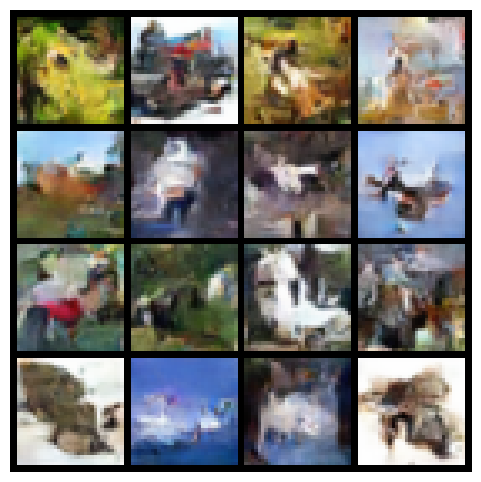

In [10]:
import numpy as np
from torchvision.utils import make_grid
import matplotlib.pyplot as plt

@torch.no_grad()
def sample_and_show(n=16, steps=None):
    steps = steps if steps is not None else cfg.sample_steps
    x = heun_sampler(
        ema_model, batch_size=n, steps=steps,
        sigma_min=cfg.sigma_min, sigma_max=cfg.sigma_max, rho=cfg.rho,
        device=device
    )
    # back to [0,1] for display
    x_vis = (x + 1.0) * 0.5
    grid = make_grid(x_vis, nrow=int(math.sqrt(n)), padding=2)
    npimg = grid.permute(1,2,0).cpu().numpy()
    plt.figure(figsize=(6,6))
    plt.imshow(np.clip(npimg, 0, 1))
    plt.axis("off")
    plt.show()

sample_and_show(n=16, steps=cfg.sample_steps)


In [11]:
@torch.no_grad()
def heun_sampler_with_energy(model_ema, batch_size=16, steps=40,
                             sigma_min=0.002, sigma_max=80.0, rho=7.0, device='cpu'):
    """Same sampler, but also returns the learned scalar v (energy/logsigma proxy) along the path."""
    model_ema.eval()
    sigmas = karras_sigma_schedule(steps, sigma_min, sigma_max, rho=rho, device=device)
    x = torch.randn(batch_size, cfg.channels, cfg.image_size, cfg.image_size, device=device) * sigmas[0]
    energies = []

    def v_head(x, sigma):
        log_sigma = torch.log(sigma.clamp(min=1e-12))
        _, v = model_ema(x, log_sigma)
        return v.mean(dim=(1,2,3))

    for i in range(steps):
        sigma_i = sigmas[i]
        sigma_next = sigmas[i+1]
        # measure "energy" at step i
        if cfg.with_v_head:
            energies.append(v_head(x, sigma_i).mean().item())

        x0_hat = denoise_fn(model_ema, x, sigma_i)
        d_i = (x - x0_hat) / sigma_i.clamp(min=1e-12)
        x_euler = x + (sigma_next - sigma_i) * d_i
        if sigma_next > 0:
            x0_hat_next = denoise_fn(model_ema, x_euler, sigma_next)
            d_next = (x_euler - x0_hat_next) / sigma_next.clamp(min=1e-12)
            x = x + (sigma_next - sigma_i) * 0.5 * (d_i + d_next)
        else:
            x = x_euler

    x = x.clamp(-1,1)
    if cfg.with_v_head:
        energies.append(v_head(x, torch.tensor(1e-6, device=device)).mean().item())
    return x, energies

# Example monitoring:
samples, energies = heun_sampler_with_energy(
    ema_model, batch_size=8, steps=cfg.sample_steps,
    sigma_min=cfg.sigma_min, sigma_max=cfg.sigma_max, rho=cfg.rho, device=device
)
print("Energy trace (avg per step):", energies[:10], "...", energies[-3:])


Energy trace (avg per step): [1.387648582458496, 1.507169246673584, 1.6506017446517944, 1.7973859310150146, 1.9207227230072021, 2.056506633758545, 2.136543035507202, 2.155430316925049, 2.194106101989746, 2.2664666175842285] ... [-4.655238151550293, -4.644486427307129, -2.144723653793335]


EMA validation losses: {'loss': 1.538277280330658, 'loss_v': 0.003523558285087347}
Gradient norm stats: {'grad_norm_mean': 0.2124004364013672, 'grad_norm_max': 0.2124004364013672, 'samples': [0.2124004364013672]}
Sampler stats: {'min': -0.9778408408164978, 'max': 0.9940329790115356, 'mean': -0.16181641817092896, 'std': 0.4795505702495575, 'mse_to_real': 0.5472103357315063, 'snr_db': -3.4610700607299805}


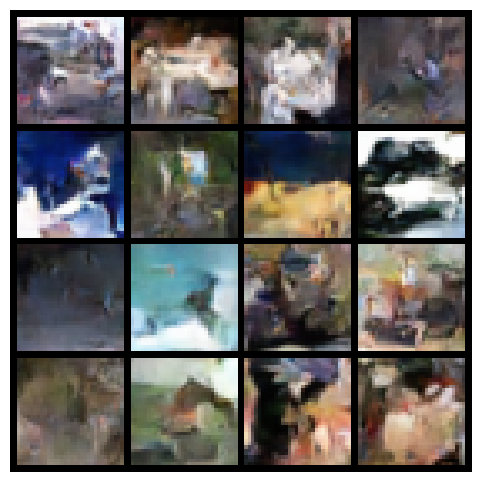

In [14]:
# Post-training diagnostics
if 'evaluate_denoiser' in globals():
    denoise_stats = evaluate_denoiser(num_batches=5)
    print("EMA validation losses:", denoise_stats)
else:
    print("Run the diagnostics cell before this one to define evaluate_denoiser().")

if 'check_gradient_health' in globals():
    grad_stats = check_gradient_health(max_batches=1)
    print("Gradient norm stats:", grad_stats)
else:
    print("Run the diagnostics cell before this one to define check_gradient_health().")

if 'sampler_quality_probe' in globals():
    samples, sampler_stats = sampler_quality_probe(batch_size=16, steps=cfg.sample_steps)
    print("Sampler stats:", sampler_stats)
    # Display the generated samples
    grid = make_grid((samples + 1.0) * 0.5, nrow=int(math.sqrt(samples.size(0))), padding=2)
    npimg = grid.permute(1,2,0).cpu().numpy()
    plt.figure(figsize=(6,6))
    plt.imshow(np.clip(npimg, 0, 1))
    plt.axis("off")
    plt.show()
else:
    print("Run the diagnostics cell before this one to define sampler_quality_probe().")

In [13]:
# FID evaluation utility (install torchmetrics==1.3.0 to enable)
try:
    from torchmetrics.image.fid import FrechetInceptionDistance
except ImportError:
    print("Install torchmetrics==1.3.0 (e.g., `pip install torchmetrics==1.3.0`) to enable FID computation.")
    compute_fid = None
else:
    @torch.no_grad()
    def compute_fid(num_real=10000, batch_size=64, steps=None):
        steps = steps or cfg.sample_steps
        fid = FrechetInceptionDistance(feature=2048, reset_real_features=True).to(device)

        collected = 0
        for x, _ in train_loader:
            real = ((x + 1.0) * 0.5).clamp(0, 1).to(device)
            real_uint8 = (real * 255.0).clamp(0, 255).to(torch.uint8)
            fid.update(real_uint8, real=True)
            collected += real.size(0)
            if collected >= num_real:
                break

        produced = 0
        while produced < num_real:
            current_bs = min(batch_size, num_real - produced)
            gen = heun_sampler(
                ema_model, batch_size=current_bs, steps=steps,
                sigma_min=cfg.sigma_min, sigma_max=cfg.sigma_max, rho=cfg.rho, device=device
            )
            gen = ((gen + 1.0) * 0.5).clamp(0, 1)
            gen_uint8 = (gen * 255.0).clamp(0, 255).to(torch.uint8)
            fid.update(gen_uint8, real=False)
            produced += current_bs

        return float(fid.compute().item())


    fid_score = compute_fid(num_real=10000, batch_size=64)
    print(f"FID (10k samples): {fid_score:.3f}")

FID (10k samples): 79.277
